In [155]:
import torch
import openai
import cv2
import librosa
import numpy as np
import subprocess
from diffusers import StableDiffusionPipeline
from transformers import pipeline
import matplotlib.pyplot as plt
import os

In [156]:
# Load YOLOv5 model
def load_yolo_model(model_path):
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True)
    return model

In [157]:
def load_speech_emotion_model():
    emotion_model = pipeline("audio-classification", model="ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
    return emotion_model

In [158]:
# Generate synthetic data using diffusion models
def generate_synthetic_data(prompt):
    model_id = "CompVis/stable-diffusion-v1-4"
    pipe = StableDiffusionPipeline.from_pretrained(model_id)
    pipe.to('cpu')
    
    # Reduce image size to prevent memory overload
    image = pipe(prompt, height=512, width=512, num_inference_steps=25).images[0]
    return image

In [159]:
# Find the latest YOLOv5 experiment directory
def get_latest_exp_dir(base_dir="yolov5/runs/detect"):
    exp_dirs = [d for d in os.listdir(base_dir) if d.startswith("exp")]
    if not exp_dirs:
        return None
    latest_exp = sorted(exp_dirs, key=lambda x: int(x[3:]) if x[3:].isdigit() else 0)[-1]
    return os.path.join(base_dir, latest_exp)

In [160]:
# Perform fall detection using YOLOv5
def detect_fall(image_path, model_path):
    subprocess.run(["python", "yolov5/detect.py", "--weights", model_path, "--source", image_path, "--save-txt", "--save-crop"],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    latest_exp_dir = get_latest_exp_dir()
    if latest_exp_dir:
        image_base_name = os.path.splitext(os.path.basename(image_path))[0]
        for ext in [".jpg", ".png", ".jpeg"]:
            detected_image_path = os.path.join(latest_exp_dir, f"{image_base_name}{ext}")
            if os.path.exists(detected_image_path):
                return cv2.imread(detected_image_path), detected_image_path
    
    print("No processed detection image found.")
    return None, None

In [161]:
# Perform speech emotion analysis
def analyze_speech_emotion(audio_path, emotion_model):
    try:
        audio, sr = librosa.load(audio_path, sr=16000, mono=True, res_type="kaiser_fast")
    except Exception as e:
        print(f"Error loading audio: {e}")
        return "Error analyzing speech."
    
    results = emotion_model(audio[:sr*3])  # Analyze first 3 seconds
    
    # Extract dominant emotion
    if results:
        dominant_emotion = max(results, key=lambda x: x['score'])
        emotion_label = dominant_emotion['label']
        emotion_confidence = dominant_emotion['score']
        print(f"Detected emotion: {emotion_label} with confidence {emotion_confidence:.4f}")
        return f"{emotion_label}"  # Returning only the label
    else:
        print("No emotion detected.")
        return "No emotion detected."

In [162]:
# Generate description of detected image
def describe_detected_image(image_path):
    if image_path is None:
        return "No image detected to describe."
    
    prompt = "Describe the content of the following image: " + image_path
    description = f"The detected image at {image_path} likely contains a scene related to fall detection, highlighting an individual in distress or an annotated detection box."
    print("Image Description:", description)
    return description

In [163]:
# Display image
def display_image(image, title="Image"):
    if image is None:
        print(f"Error: Unable to load {title}")
        return
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [164]:
# Main pipeline
def main_pipeline(image_path, audio_path, model_path):
    emotion_model = load_speech_emotion_model()
    
    detected_image, detected_image_path = detect_fall(image_path, model_path)
    speech_emotion = analyze_speech_emotion(audio_path, emotion_model)
    
    image_description = describe_detected_image(detected_image_path)
    synthetic_image = generate_synthetic_data("An elderly person falling")
    
    return {
        "detected_image": detected_image,
        "speech_emotion": speech_emotion,
        "image_description": image_description,
        "synthetic_image": synthetic_image
    }

/Users/nanxuan/miniconda3/envs/dscapstone/lib/python3.9/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSeque

Detected emotion: sad with confidence 0.1352
Image Description: The detected image at yolov5/runs/detect/exp/1.jpeg likely contains a scene related to fall detection, highlighting an individual in distress or an annotated detection box.


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


Speech Emotion Analysis:
sad
Image Description:
The detected image at yolov5/runs/detect/exp/1.jpeg likely contains a scene related to fall detection, highlighting an individual in distress or an annotated detection box.
Displaying detected image...


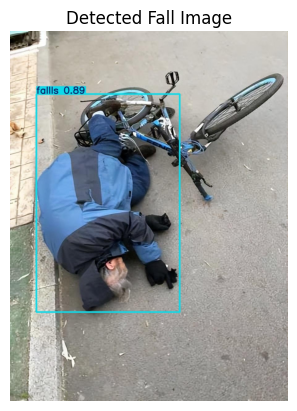

In [165]:
if __name__ == "__main__":
    image_path = "Data/1.jpeg"
    audio_path = "Data/DC_a01.wav"  
    model_path = "best.pt" 
    results = main_pipeline(image_path, audio_path, model_path)
    print("Speech Emotion Analysis:")
    print(results["speech_emotion"])
    
    print("Image Description:")
    print(results["image_description"])
    
    print("Displaying detected image...")
    display_image(results["detected_image"], title="Detected Fall Image")


In [1]:
!streamlit run app.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.10.68.233:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/nanxuan/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-2-25 Python-3.9.21 torch-2.6.0 CPU

Fusing layers... 
Model summary: 322 layers, 86180143 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 
Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequence